In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


In [29]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetV2S
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

def create_hybrid_resnet_efficientnet_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # --- ResNet50 branch ---
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    resnet_base.trainable = False
    x1 = tf.keras.applications.resnet.preprocess_input(inputs)
    x1 = resnet_base(x1, training=False)
    x1 = GlobalAveragePooling2D()(x1)

    # --- EfficientNetV2S branch ---
    efficientnet_base = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=input_shape)
    efficientnet_base.trainable = False
    x2 = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    x2 = efficientnet_base(x2, training=False)
    x2 = GlobalAveragePooling2D()(x2)


    x = Concatenate()([x1, x2])  # Hybrid feature vector

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model


In [30]:
model = create_hybrid_resnet_efficientnet_model(input_shape=(224, 224, 3))
model.load_weights('hybrid_gender_weights.weights.h5')
print("✅ Weights loaded successfully.")


✅ Weights loaded successfully.


In [38]:
def evaluate_entire_dataset(model, val_dir, image_size=(224, 224)):
    total_images = 0
    total_correct = 0

    total_male = 0
    total_female = 0
    correct_male = 0
    correct_female = 0

    y_true = []
    y_pred = []

    for label in ['male', 'female']:
        class_dir = os.path.join(val_dir, label)
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, fname)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                img_array = tf.expand_dims(img_array, axis=0)
                img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

                pred_prob = model.predict(img_array, verbose=0)[0][0]
                pred_label = 'male' if pred_prob > 0.5 else 'female'

                true_label = label
                y_true.append(1 if true_label == 'male' else 0)
                y_pred.append(1 if pred_label == 'male' else 0)

                total_images += 1
                if true_label == 'male':
                    total_male += 1
                    if pred_label == 'male':
                        correct_male += 1
                        total_correct += 1
                else:
                    total_female += 1
                    if pred_label == 'female':
                        correct_female += 1
                        total_correct += 1

    overall_acc = (total_correct / total_images) * 100

    print("\n✅ Evaluation Summary:")
    print(f"✅ Overall Accuracy           : {overall_acc:.2f}%\n")

    print(f" Male Images     → Total: {total_male}, Correct: {correct_male}, Incorrect: {total_male - correct_male}")
    print(f" Female Images   → Total: {total_female}, Correct: {correct_female}, Incorrect: {total_female - correct_female}")

    # Compute metrics first!
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Female', 'Male']))
    print(f"F1 Score     : {f1:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



✅ Evaluation Summary:
✅ Overall Accuracy           : 85.55%

 Male Images     → Total: 343, Correct: 305, Incorrect: 38
 Female Images   → Total: 79, Correct: 56, Incorrect: 23

Classification Report:

              precision    recall  f1-score   support

      Female       0.60      0.71      0.65        79
        Male       0.93      0.89      0.91       343

    accuracy                           0.86       422
   macro avg       0.76      0.80      0.78       422
weighted avg       0.87      0.86      0.86       422

F1 Score     : 0.9091
Precision    : 0.9299
Recall       : 0.8892


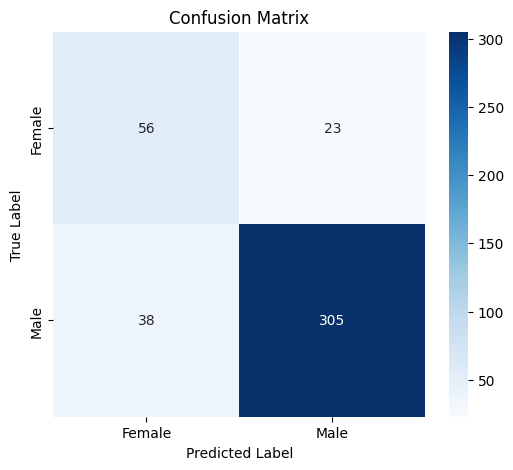

In [39]:
# Replace this with your local validation directory
val_path = val_path = r"C:\Users\SOUPTIK MALLICK\Downloads\Comys_Hackathon5\Comys_Hackathon5\Task_A\val"


evaluate_entire_dataset(model, val_path, image_size=(224, 224))
